# Data Source and reference

- The data is collected from the source https://github.com/CSSEGISandData/COVID-19
- This is the data repository for the 2019 Novel Coronavirus Visual Dashboard operated by the 
`Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)`.
 Also, Supported by `ESRI Living Atlas Team and the Johns Hopkins University Applied Physics Lab (JHU APL)`.
 
- You can view their dashboard at
 https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6
 
 #### For SIR model fitting and analysis, we are taking help from the blogposts: 
 
 
 
 - https://towardsdatascience.com/infectious-disease-modelling-part-i-understanding-sir-28d60e29fdfc
 - https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4
 - https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7 
 


In [1]:
import pandas as pd
from IPython.display import Image
import os
%matplotlib inline 
COUNTRY = 'India'

In [2]:
conf_case = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
conf_death = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
conf_recovered = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

In [3]:
cdf_conf_case = conf_case[conf_case['Country/Region']==COUNTRY].sum().drop(['Province/State','Country/Region','Lat','Long'])
cdf_conf_death = conf_death[conf_death['Country/Region']==COUNTRY].sum().drop(['Province/State','Country/Region','Lat','Long'])
cdf_conf_recovered = conf_recovered[conf_recovered['Country/Region']==COUNTRY].sum().drop(['Province/State','Country/Region','Lat','Long'])

In [4]:
def perDayCalc(totalList):
    pdf = []
    for idx, num in enumerate(totalList):
        if idx == 0:
            pdf.append(num)
            prev = num
        else:
            pdf.append(num - prev)
            prev = num
    return pdf

def rateOfChange(totalList, interval=5):
    changeVal = []
    changePer = []
    for idx, num in enumerate(totalList):
        if idx < interval:
            changeVal.append(sum(totalList[:(idx+1)])/(idx+1))
        else:
            changeVal.append(sum(totalList[idx-interval+1:(idx+1)])/interval)
    for idx, newVal in enumerate(changeVal):
        if idx == 0:
            changePer.append(0)
            prevVal = newVal
        elif prevVal!=0:
            changePer.append(100*(newVal-prevVal)/prevVal)
            prevVal = newVal
        else:
            changePer.append(1)
            prevVal = newVal
    changePer = [i%35 for i in changePer]
    return changePer #changeVal

def doublingRate(changePer):
    return [np.log(2)/np.log(1+(per/100)) for per in changePer]

In [5]:
cdf_case_list = cdf_conf_case.to_frame().T.sum().tolist()
cdf_death_list = cdf_conf_death.to_frame().T.sum().tolist()
cdf_recovered_list = cdf_conf_recovered.to_frame().T.sum().tolist()
cdf_active_list = np.subtract(np.subtract(cdf_case_list, cdf_recovered_list).tolist(), cdf_death_list).tolist()

pdf_case_list = perDayCalc(cdf_case_list)
pdf_death_list = perDayCalc(cdf_death_list)
pdf_recovered_list = perDayCalc(cdf_recovered_list)
pdf_active_list = perDayCalc(cdf_active_list)

### Cummulative visualization of COVID-19 cases in India since inception

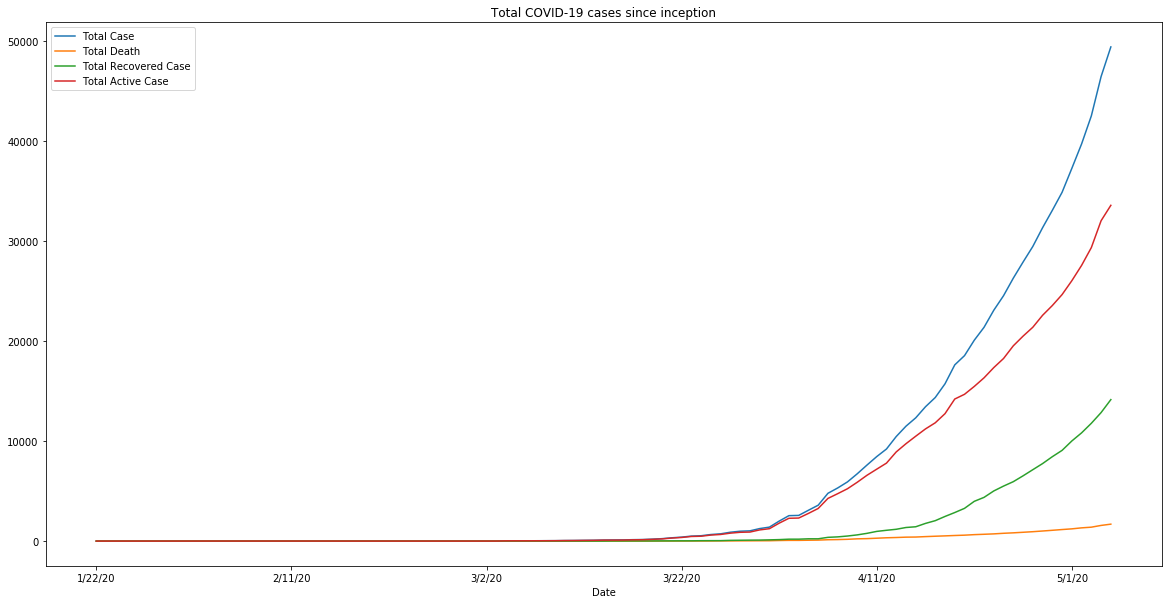

In [6]:
data = {"Date": cdf_conf_case.to_frame().T.columns.to_list(),
        "Total Case": cdf_case_list, 
        "Total Death": cdf_death_list, 
        "Total Recovered Case": cdf_recovered_list, 
        "Total Active Case": cdf_active_list}
df = pd.DataFrame(data).set_index("Date")
df.plot(figsize=(20, 10), title ="Total COVID-19 cases since inception", fontsize = 10, kind="line")
plt.show()

### Daily basis newly added case visualization along with active cases

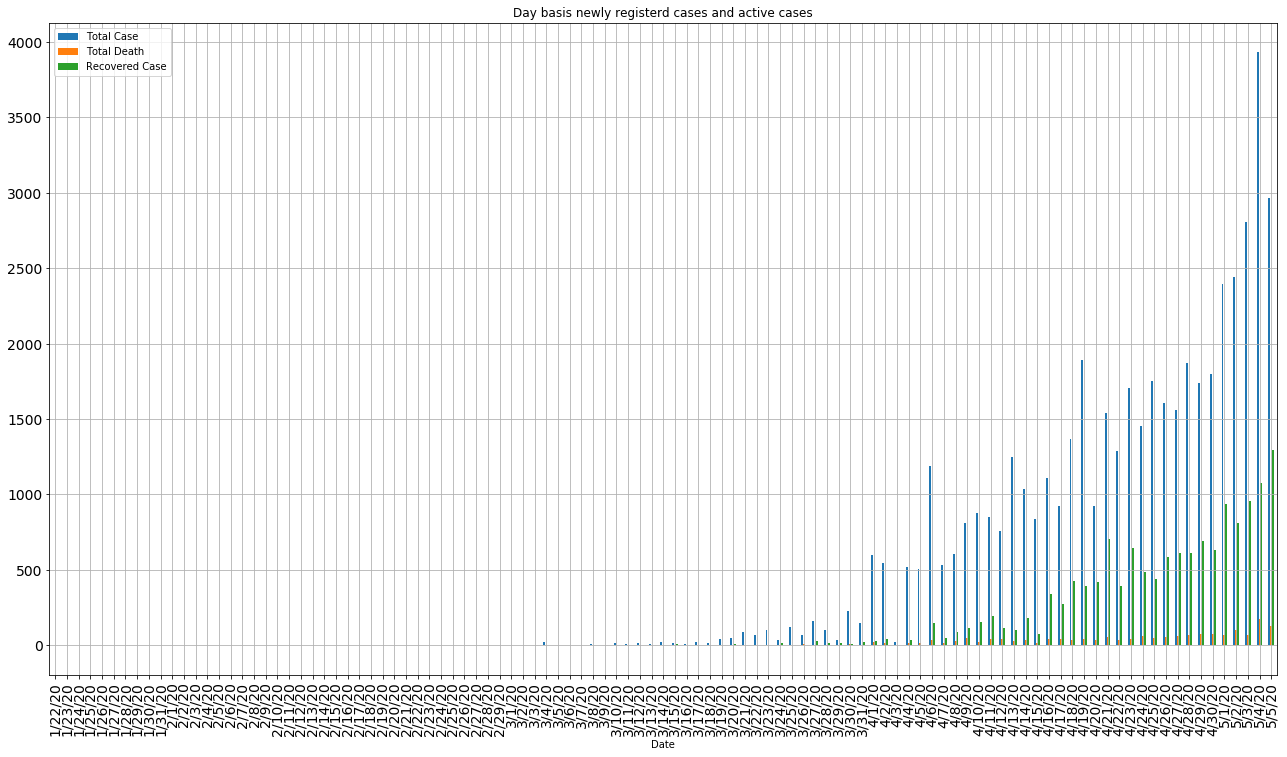

In [7]:
data = {"Date": cdf_conf_case.to_frame().T.columns.to_list(),
        "Total Case": pdf_case_list, 
        "Total Death": pdf_death_list, 
        "Recovered Case": pdf_recovered_list, 
        "Active Case": pdf_active_list}
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
data = dictfilt(data, ("Total Case", "Recovered Case", "Total Death", 'Date'))
df = pd.DataFrame(data).set_index("Date")
df.plot(figsize=(22, 12), title ="Day basis newly registerd cases and active cases", fontsize = 14, 
        kind="bar", grid = True)
plt.show()

In [8]:
print(f"Total New cases added on last day: {np.round(df.iloc[-1].tolist()[0], 0)}")
print(f"Total Death cases added on last day: {np.round(df.iloc[-1].tolist()[1], 0)}")
print(f"Total Recovered cases added on last day: {np.round(df.iloc[-1].tolist()[2], 0)}")

Total New cases added on last day: 2963.0
Total Death cases added on last day: 127.0
Total Recovered cases added on last day: 1295.0


# Rate of Increase of COVID-19 cases

### Percentage wise increment of daily NEW cases as compared to previous day

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


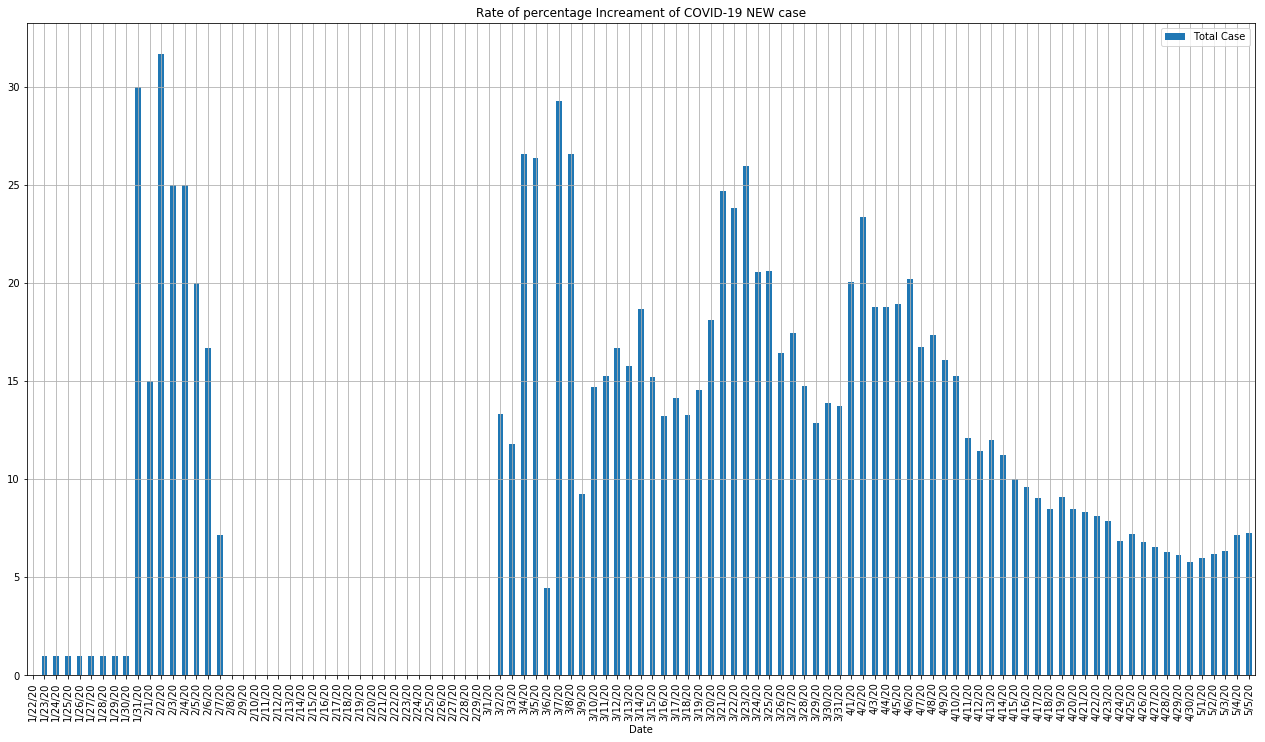

In [9]:
data = {"Date": cdf_conf_case.to_frame().T.columns.to_list(),
        "Total Case": rateOfChange(cdf_case_list), 
        "Total Death": rateOfChange(cdf_death_list), 
        "Recovered Case": rateOfChange(cdf_recovered_list), 
        "Active Case": rateOfChange(cdf_active_list),
        "Doubling rate of Total Case": doublingRate(rateOfChange(cdf_case_list))
       }
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
data = dictfilt(data, ("Total Case", 'Date'))
df = pd.DataFrame(data).set_index("Date")
df.plot(figsize=(22, 12), title ="Rate of percentage Increament of COVID-19 NEW case", fontsize = 10, kind="bar", grid = True)
plt.show()

In [10]:
print(f"Percentage increment of total cases as compared to previous day: {np.round(df.iloc[-1].tolist()[0], 2)}%")

Percentage increment of total cases as compared to previous day: 7.24%


### Percentage wise increment of daily ACTIVE cases as compared to previous day

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


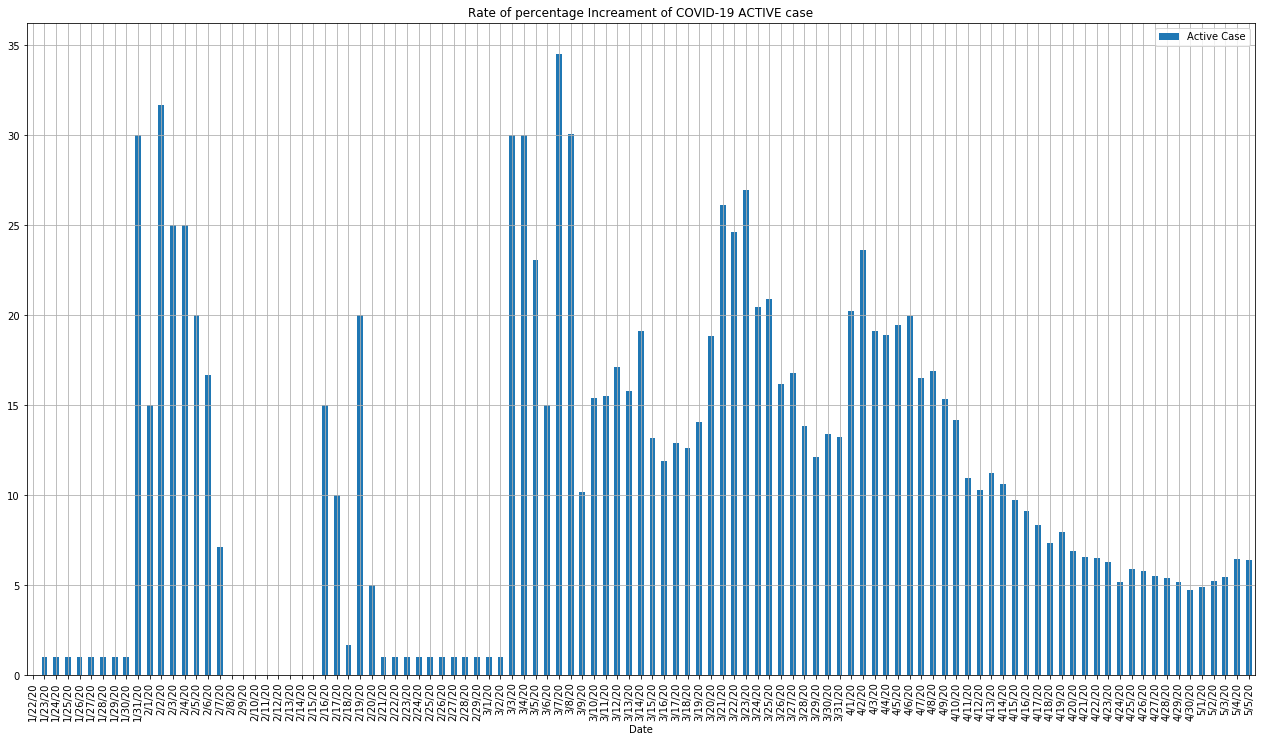

In [11]:
data = {"Date": cdf_conf_case.to_frame().T.columns.to_list(),
        "Total Case": rateOfChange(cdf_case_list), 
        "Total Death": rateOfChange(cdf_death_list), 
        "Recovered Case": rateOfChange(cdf_recovered_list), 
        "Active Case": rateOfChange(cdf_active_list),
        "Doubling rate of Total Case": doublingRate(rateOfChange(cdf_case_list))
       }
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
data = dictfilt(data, ("Active Case", 'Date'))
df = pd.DataFrame(data).set_index("Date")
df.plot(figsize=(22, 12), title ="Rate of percentage Increament of COVID-19 ACTIVE case", fontsize = 10, kind="bar", grid = True)
plt.show()

In [12]:
print(f"Percentage increment of active cases as compared to previous day: {np.round(df.iloc[-1].tolist()[0], 2)}%")

Percentage increment of active cases as compared to previous day: 6.39%


### Doubling rate of the cases in last 5 days

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


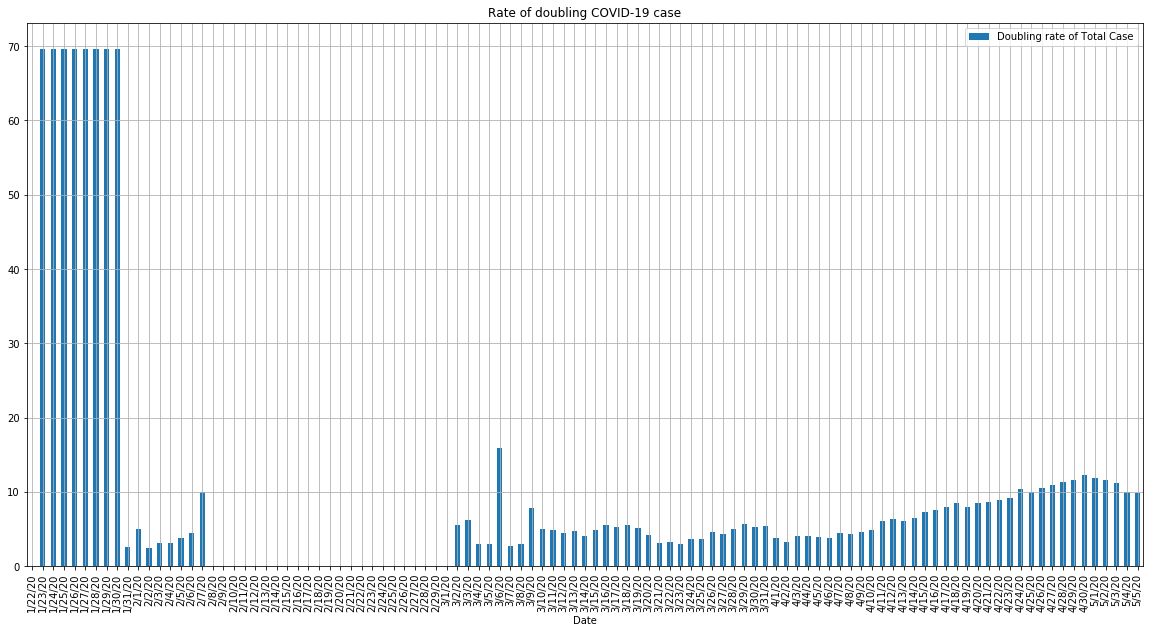

In [13]:
data = {"Date": cdf_conf_case.to_frame().T.columns.to_list(),
        "Total Case": rateOfChange(cdf_case_list), 
        "Total Death": rateOfChange(cdf_death_list), 
        "Recovered Case": rateOfChange(cdf_recovered_list), 
        "Active Case": rateOfChange(cdf_active_list),
        "Doubling rate of Total Case": doublingRate(rateOfChange(cdf_case_list))
       }
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
data = dictfilt(data, ("Doubling rate of Total Case", 'Date'))
df = pd.DataFrame(data).set_index("Date")
df.plot(figsize=(20, 10), title ="Rate of doubling COVID-19 case", fontsize = 10, kind="bar", grid = True)
plt.show()

In [14]:
print(f"Doubling rate of cases: {np.round(df.iloc[-1].tolist()[0], 2)} days")

Doubling rate of cases: 9.92 days


# Epidemic modelling using Extended SIR and fitting it to COVID-19 data

Models are always simplifications of the real world. It is a way to put the real world scenarios in some mathemetical equation so that we can derive/infer information out of it. To model something, we have to assume some facts in the first place for the sake of simplicity and interpretability.

In Data Science terminology, these are some handcrafted features we are building to approximate the current COVID-19 scenarion. SIR(Susceptible, Infected, Recovered) is a very popular model for infectious diseases modelling. But the simple vanila SIR won't help us much in real life scenario. Thats why, here we are building a extended SIR model for COVID-19 India scenario.

### Paramenters/Features

- N: total population
- S(t): number of people susceptible on day t
- E(t): number of people exposed on day t
- I(t): number of people infected on day t
- R(t): number of people recovered on day t
- D(t): number of people dead on day t
- β: expected amount of people an infected person infects per day
- D: number of days an infected person has and can spread the disease
- γ: the proportion of infected recovering per day (γ = 1/D)
- R₀: the total number of people an infected person infects (R₀ = β / γ)
- δ: length of incubation period
- α: fatality rate
- ρ: rate at which people die (= 1/days from infected until death)

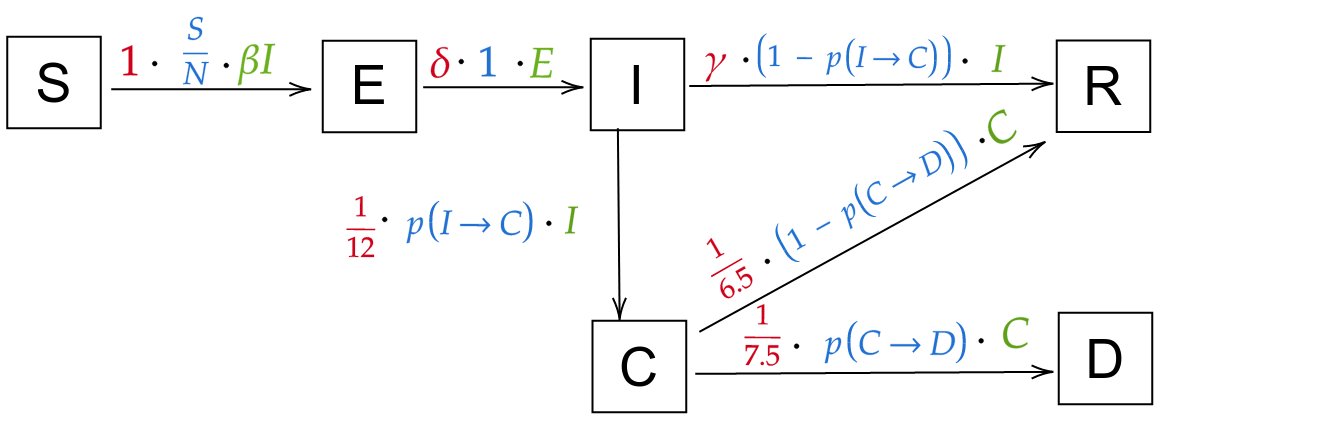

Below are the equations that go with it

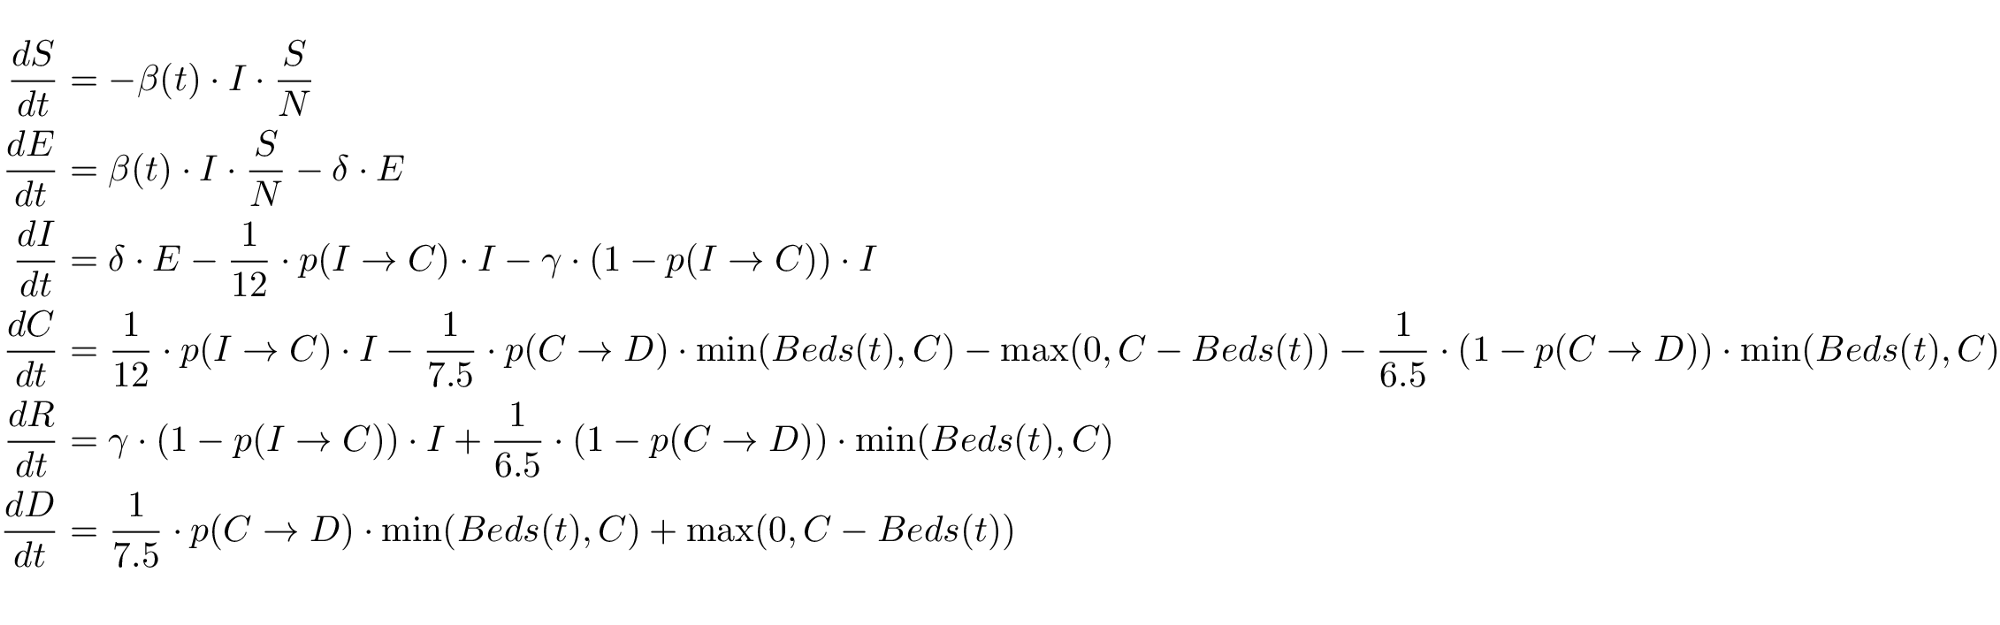

In [15]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

In [16]:
# Load the data
ROOT_DIR = "D:/New folder/Covid19-India-finding-insight/data"
beds = pd.read_csv(os.path.join(ROOT_DIR, "beds.csv"), header=0)
agegroups = pd.read_csv(os.path.join(ROOT_DIR, "agegroups.csv"))
probabilities = pd.read_csv(os.path.join(ROOT_DIR, "probabilities.csv"))

covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]


beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
agegroup_lookup = dict(zip(agegroups['Location'], 
                           agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', 
                                      '50_59', '60_69', '70_79', '80_89', '90_100']].values))

prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

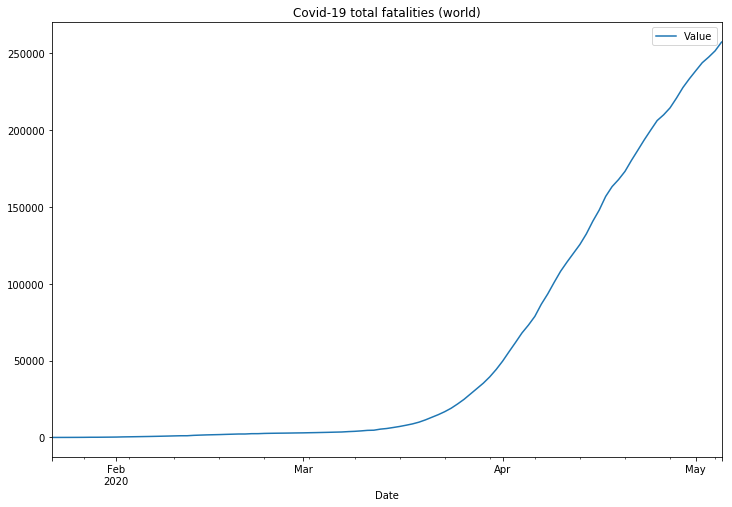

In [20]:
covid_data.groupby("Date").sum()[["Value"]].plot(figsize=(12, 8), title="Covid-19 total fatalities (world)")

## Model definition

In [21]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [22]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

In [23]:
def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
        print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")

    f, ax = plt.subplots(1,1,figsize=(13,6))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(13,6))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

## Fitting to available India's data

In [24]:
data = covid_data[covid_data["Location"] == "India"]["Value"].values[::-1]
agegroups = agegroup_lookup["India"]
beds_per_100k = beds_lookup["India"]
outbreak_shift = 30
# parameters to fit; form: {parameter: (initial guess, minimum value, max value)}
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), 
                       "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}

In [25]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [26]:
def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [27]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [28]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

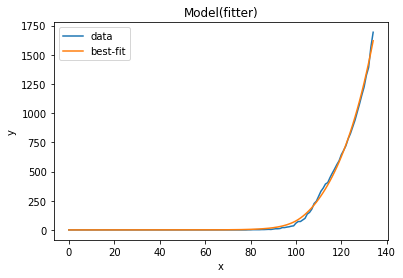

In [29]:
result.plot_fit(datafmt="-")

In [30]:
result.best_values

{'R_0_start': 3.2124291874483233,
 'k': 4.999907424277086,
 'x0': 99.13559269371902,
 'R_0_end': 1.7127801555365811,
 'prob_I_to_C': 0.010000001434844547,
 'prob_C_to_D': 0.05000060272486658,
 's': 0.003}

In [38]:
print(f"Current R0 value in India is:{result.best_values['R_0_end']}")

Current R0 value in India is:1.7127801555365811


Prediction for India
percentage going to ICU: 1.0000001434844548; percentage dying in ICU: 5.0000602724866585


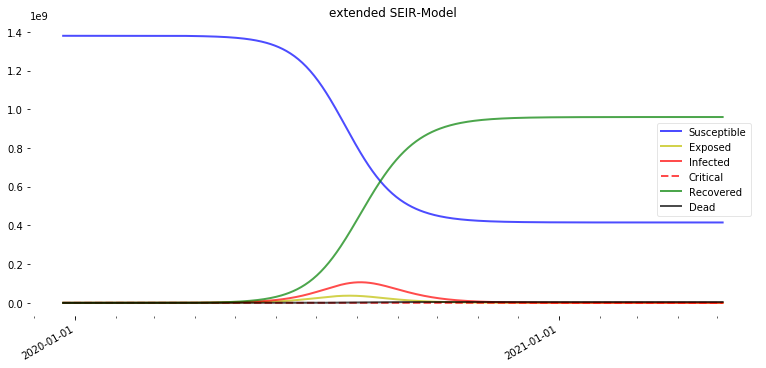

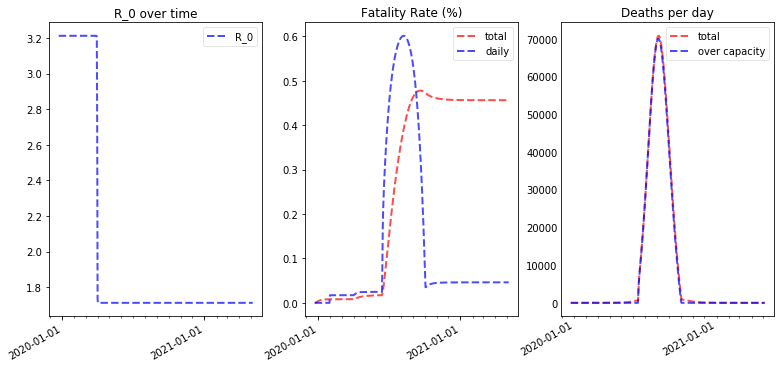

In [39]:
full_days = 500
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for India")
plotter(*Model(full_days, agegroup_lookup["India"], beds_lookup["India"], **result.best_values), x_ticks=x_ticks);

### Finding R-naught value using over simplified method(Not so correct)

The `R-Naught` of a disease, or the `contagiousness`, represents how transmissible the disease is. An R-Naught of 2 means that for every one person with the disease, two more people are infected. A fractional R-Naught means that the epidemic is dying down. Hepatitis C and Ebola have an R-Naught of 2, HIV and SARS 4, and Measles 18, to give a few examples.


The `R-Naught (R0)` of a disease is usually publicly declared by the World Health Organization after careful and lengthy analysis of various factor such as the infectious period, contact rate, mode of transmission, etc.
In this article, we’ll handwrite a program that optimizes an exponential model to the data to find the R0 of the coronavirus in Python. While this is in no means a substitute for the WHO and other health agencies’ findings, it is a good way to gauge just how contagious the coronavirus is with the current lack of information.


In this notebook, we’ll handwrite a program that optimizes an exponential model to the data to find the R0 of the coronavirus in Python. While this is in no means a substitute for the WHO and other health agencies’ findings, it is a good way to gauge just how contagious the coronavirus is with the current lack of information.

### R-naught Model

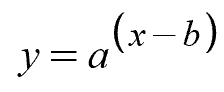

In [179]:
Image(filename='a.png')

Our model will have a very simple equation stated above:

…where y is the forecasted number of cases and x is the number of days since the first confirmed case. a and b are the only two parameters that will allow changing.

a controls how steep the curve will be. A smaller a value represents a less steep curve, and a higher a value represents a steeper curve.

a is also the R0 value. For each number of days x after the epidemic begins, the number of new cases multiplies by a factor of a — for every one person infected on day x, a more people will be infected on day x + 1.
This also provides another representation of what different quantities of R0 values mean.

### Fitting the Model

In [442]:
'''
learning_rate = 0.001
a = 1
b = 4
y = conf_case[conf_case['Country/Region']=='India'].sum().drop(['Province/State','Country/Region','Lat','Long']).tolist()
x = range(len(y))

def cost_function(a, b, x, y):
    error = 0
    for index in x:
        error += abs((a**(x[index]-b)) - (y[index]))#**2
    return error / len(x)

def training(a, b, x, y, learning_rate):
    print(f"Initial a: {a}")
    print(f"Initial b: {b}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Initial Cost Function: {cost_function(a, b, x, y)}\n")
    from math import log
    for index in x:
        if 0.9*x[index] < b+1 < 1.1*x[index]:
            #pass
            continue
        a_old = a
        a = a - ( learning_rate * 2 * ((a**(x[index]-b)) - (y[index])) * (x[index] - b) * (a**(x[index]-b-1)) )
        if a < 0 or a == float("inf") or a == float("-inf"):
            a = a_old
            continue
        b_old = b
        b = b - ( learning_rate * 2 * ((a**(x[index]-b)) - (y[index])) * (a**(x[index]-b)) * log(a) )
        if b == float("inf") or b == float("-inf"):
            b = b_old
            continue
        if False:#index % 5 == 0:
            print(f"ITERATION {index+1}:")
            print(f"New a: {a}")
            print(f"New b: {b}")
            print(f'Cost Function:  {cost_function(a, b, x, y)}\n')
    print(f"ITERATION {index+1}:")
    print(f"Final a: {a}, \nFinal b: {b}")
    print(f'Cost Function:  {cost_function(a, b, x, y)}\n')
    return a, b

def multiple_train(a, b, x, y, learning_rate, epoch):
    for e in range(epoch):
        a, b = training(a=a, b=b, x=x, y=y, learning_rate=learning_rate)
        print(f"\n\n\n\nEPOCH: {e}")
        print("{'A':"+str(a)+", 'B':"+str(b)+"}")
        print(f"ERROR: {cost_function(a, b, x, y)}")
    return a, b


multiple_train(a=1.2, b=4, x=x, y=y, learning_rate=0.00001, epoch=2)
'''

In [59]:
y = np.array(cdf_case_list)
#y = np.array(cdf_active_list)
x = np.array(range(len(y)))

### Curve fitting using LMFIT

In [61]:
from scipy.optimize import leastsq
from lmfit import minimize, Parameters
params = Parameters()
params.add('a', value=1.0)
params.add('b', value=5.0)

def get_residual(params, x, data):
    a = params['a'].value
    b = params['b'].value
    model = a**(x-b)
    return data - model

In [62]:
out = minimize(fcn=get_residual, params=params, method='leastsq', args=(x, y))
a, b = out.__dict__['params']['a'].value, out.__dict__['params']['b'].value

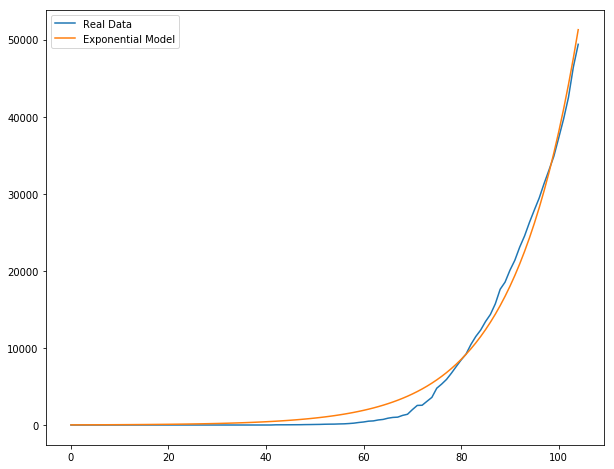

In [63]:
best_set = {'A':a, 'B':b}
def function(x):
    return best_set['A']**(x-best_set['B'])

plt.figure(figsize=(10,8))
plt.plot(x,y,label='Real Data')
plt.plot(x,[function(i) for i in x],label='Exponential Model')
plt.legend()
plt.show()

### Results

In [64]:
print(f"The R0 value on today is: {np.round(a, 2)}")
print(f"For initial \'a\': 1.00 and \'b\': 5.00,  MEAN ABSOLUTE ERROR was: \
    {np.round(sum(abs(get_residual(params=params, x=x, data=y)))/len(x), 2)}")

params1 = Parameters()
params1.add('a', value=a)
params1.add('b', value=b)
print(f"For final \'a\': {np.round(a, 2)} and \'b\': {np.round(b, 2)}, MEAN ABSOLUTE ERROR is:   \
    {np.round(sum(abs(get_residual(params=params1, x=x, data=y)))/len(x), 2)}")

The R0 value on today is: 1.08
For initial 'a': 1.00 and 'b': 5.00,  MEAN ABSOLUTE ERROR was:     6410.99
For final 'a': 1.08 and 'b': -40.95, MEAN ABSOLUTE ERROR is:       821.74
